In [1]:
import torch
import scanpy as sc
import anndata as ad

from utils.utility_fn import check_isolation
from sc_graph.build_graph import build_adj_graph, build_diffusion_graph, build_graph, build_gnd_steps_graph
from sc_graph.call_attention import call_attention, call_gnd_attention
from sc_graph.call_modularity import call_modularity, call_gnd_modularity, view_modularity
from sc_analysis.clustering import clustering, evaluate_clustering


from grand.feature_encoder import encode_features
from grand.graph_DIF import graph_diffusion



/projectnb/czproj/ycliu137/.conda/envs/graph_dif/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)
if device == 'cuda':
    print(torch.cuda.get_device_name())

cpu


In [3]:
DATA_PATH = 'data/Klein/'
DATA_TYPE = '10X'

OUTPUT_PATH = 'outputs/Klein/'

# Load dataset

In [21]:
adata = sc.read_h5ad(DATA_PATH+'klein.h5ad')

In [22]:
adata

AnnData object with n_obs × n_vars = 2717 × 24175
    obs: 'labels'
    var: 'gene_ids', 'feature_types'

# Preprocess

We use the normalized and log transformed data (NOT scaled data).

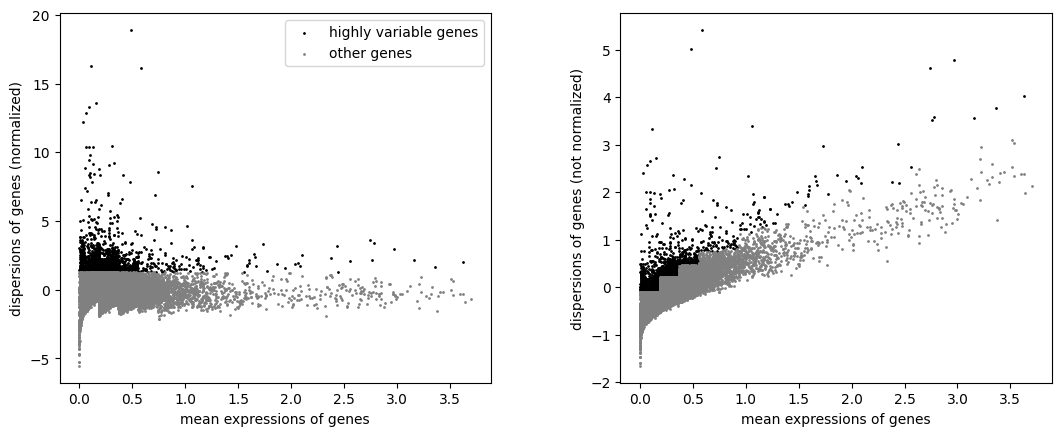

In [23]:
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)

sc.pp.highly_variable_genes(adata, n_top_genes =2000, min_mean=0.0125, max_mean=9, min_disp=0.5)
sc.pl.highly_variable_genes(adata)


In [24]:
adata.raw = adata

adata = adata[:, adata.var.highly_variable]
#sc.pp.scale(adata, max_value=10)

In [25]:
adata

View of AnnData object with n_obs × n_vars = 2717 × 2000
    obs: 'labels'
    var: 'gene_ids', 'feature_types', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'log1p', 'hvg'

# Feature encoder

In [27]:
adata = encode_features(adata, D_encode_list=[2000, 300, 50], D_decode_list=[50, 300, 2000], 
                      max_epoch=2000, lr=1e-3, 
                    device=device, 
                    activation=torch.nn.ELU(), 
                 encode_last_activation=False, decode_last_activation=False)

adata.write(OUTPUT_PATH+'encoded_adata.h5ad')

--------> Starting feature encoder ...
------------------------> Epoch: 1/2000, Current loss: 1337702.7500


/projectnb/czproj/Algorithms/ycliu/scDiffusion/grand/feature_encoder.py:38: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  target_1 = torch.tensor(feature_matrix.to(device), dtype = feature_matrix_recover.dtype)


------------------------> Epoch: 51/2000, Current loss: 562196.3125
------------------------> Epoch: 101/2000, Current loss: 531692.4375
------------------------> Epoch: 151/2000, Current loss: 511032.3125
------------------------> Epoch: 201/2000, Current loss: 493039.0312
------------------------> Epoch: 251/2000, Current loss: 480811.2500
------------------------> Epoch: 301/2000, Current loss: 472940.0000
------------------------> Epoch: 351/2000, Current loss: 466073.0000
------------------------> Epoch: 401/2000, Current loss: 460932.3125
------------------------> Epoch: 451/2000, Current loss: 455635.5625
------------------------> Epoch: 501/2000, Current loss: 450065.3125
------------------------> Epoch: 551/2000, Current loss: 443916.8125
------------------------> Epoch: 601/2000, Current loss: 438080.6250
------------------------> Epoch: 651/2000, Current loss: 430150.2500
------------------------> Epoch: 701/2000, Current loss: 422719.0000
------------------------> Epoch: 75

/projectnb/czproj/Algorithms/ycliu/scDiffusion/grand/feature_encoder.py:55: ImplicitModificationWarning: Setting element `.obsm['X_fae']` of view, initializing view as actual.
  adata.obsm['X_fae'] = feature_matrix_encoded.detach().cpu().numpy()


In [4]:
adata = ad.read_h5ad(OUTPUT_PATH+'encoded_adata.h5ad')

### View umap of the encoded data

In [28]:
sc.pp.neighbors(adata, use_rep='X_fae', n_neighbors=10, n_pcs=50)
sc.tl.umap(adata)

/projectnb/czproj/ycliu137/.conda/envs/graph_dif/lib/python3.9/site-packages/numba/np/ufunc/parallel.py:371: NumbaWarning: The TBB threading layer requires TBB version 2021 update 6 or later i.e., TBB_INTERFACE_VERSION >= 12060. Found TBB_INTERFACE_VERSION = 12040. The TBB threading layer is disabled.
  warnings.warn(problem)


/projectnb/czproj/ycliu137/.conda/envs/graph_dif/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


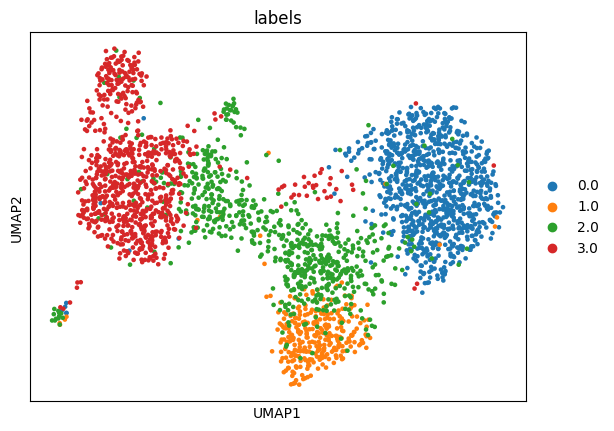

In [30]:
sc.pl.umap(adata, color=['labels'])

### Check isolation nodes

In [31]:
adata = check_isolation(adata, use_rep='X_fae', predict_pct=0.05)

/projectnb/czproj/ycliu137/.conda/envs/graph_dif/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


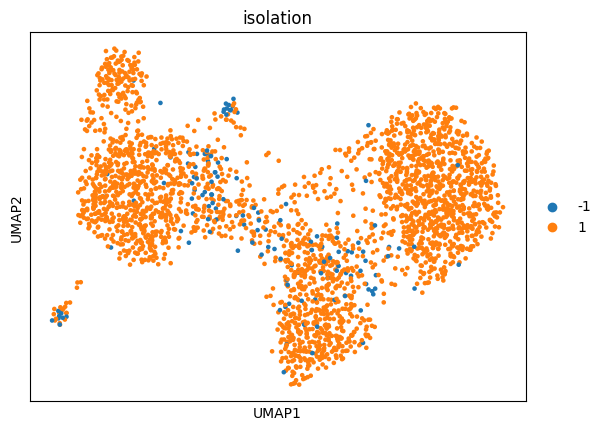

In [6]:
sc.pl.umap(adata, color=['isolation'])

The isolation inofrmation can be used to prune edges for single cell graph.

# Diffusion

In [7]:
adata = build_adj_graph(adata, use_rep=None, k=50, data_dtype = torch.float32, device=device)

This graph provides the adjacency that can be used in loss function.

## Build diffusion based graph

In [8]:
adata = build_diffusion_graph(adata, use_rep=None, k_min=0, k_max=10, self_edge = False, remov_edge_prob=None, 
                              prune=False, device=device)


This graph is used in the graph neural diffusion process.

If prune=True, edges will be pruned according to the isolation labels for graph-nodes.

In [ ]:
adata = graph_diffusion(adata, use_rep='X_fae', max_epoch=2000, lr=1e-4, device=device,
                           num_features_diffusion=50,
                           num_heads_diffusion=6,
                           num_steps_diffusion=8, 
                           time_increment_diffusion=0.1,
                           attention_type = 'sum', 
                           activation=torch.nn.ELU(),
                           dropout=0.0,  
                           encoder=None, 
                           decoder=[300],
                           save_model = True,
                           log_diffusion=True,
                           load_model_state = False,
                           loss_adj=0.0,
                           use_adj='adj_edge_index',
                           loss_reduction = "sum",
                           rebuild_graph=False,
                           rebuild_graph_args={
                               'k_min': 0,
                               'k_max': 10,
                               'remov_edge_prob': None,
                           }
                           )

adata.write(OUTPUT_PATH+'diffused_adata.h5ad')



--------> Starting Graph AE ...


/projectnb/czproj/Algorithms/ycliu/scDiffusion/grand/graph_DIF.py:114: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  target_1 = torch.tensor(adjacency, dtype = recon_adj.dtype)
/projectnb/czproj/Algorithms/ycliu/scDiffusion/grand/graph_DIF.py:115: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  target_2 = torch.tensor(target_features, dtype = out_nodes_features.dtype)


------------------------> Epoch: 1/2000, Current loss: 2256180.5000
------------------------> Epoch: 51/2000, Current loss: 878875.0000
------------------------> Epoch: 101/2000, Current loss: 703184.7500
------------------------> Epoch: 151/2000, Current loss: 642469.0625
------------------------> Epoch: 201/2000, Current loss: 609342.8125
------------------------> Epoch: 251/2000, Current loss: 586804.3750
------------------------> Epoch: 301/2000, Current loss: 569841.0625
------------------------> Epoch: 351/2000, Current loss: 556396.4375
------------------------> Epoch: 401/2000, Current loss: 545431.5625
------------------------> Epoch: 451/2000, Current loss: 536315.4375
------------------------> Epoch: 501/2000, Current loss: 528620.0625
------------------------> Epoch: 551/2000, Current loss: 522039.6875
------------------------> Epoch: 601/2000, Current loss: 516350.6250
------------------------> Epoch: 651/2000, Current loss: 511386.4688
------------------------> Epoch: 701

In [5]:
adata = ad.read_h5ad(OUTPUT_PATH+'diffused_adata.h5ad')


# View UMAP for diffused data

In [36]:
sc.pp.neighbors(adata, use_rep='X_dif', n_neighbors=10, n_pcs=50)
sc.tl.umap(adata)

/projectnb/czproj/ycliu137/.conda/envs/graph_dif/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


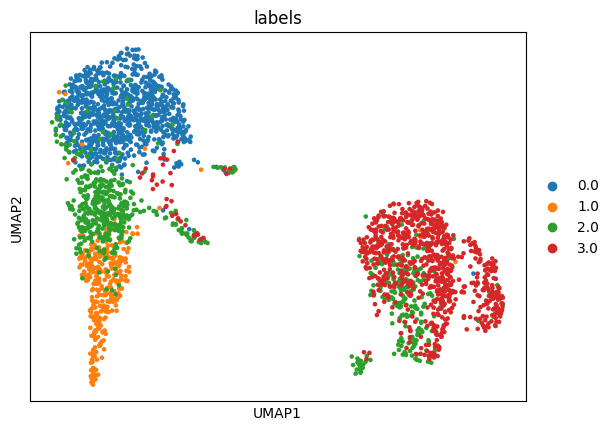

In [37]:
sc.pl.umap(adata, color=['labels'])

# Clustering

In [39]:
adata = build_graph(adata, use_rep="X_dif", k=10, self_edge = False, prune=False, 
                    data_dtype = torch.float32, device=device)

If prune=True, edges will be pruned according to the isolation labels for graph-nodes.

In [40]:
adata = call_attention(adata, attention_type=None, num_heads_diffusion=None, dropout=None, device=device)

In [41]:
adata = clustering(adata, resolution=0.05, initial_membership=None)

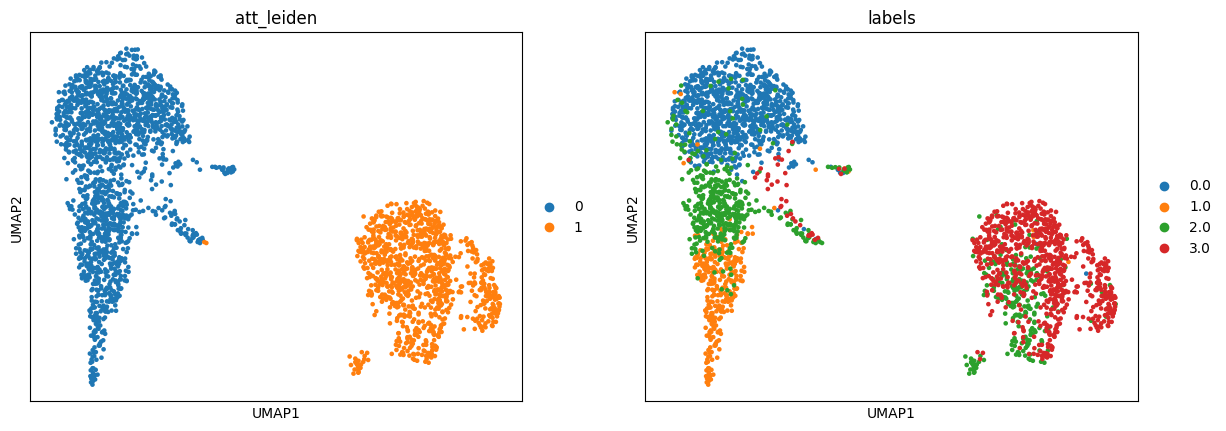

In [43]:
sc.pl.umap(adata, color=['att_leiden', 'labels',])

In [23]:
evaluate_clustering(adata.obs['att_leiden'], adata.obs['celltype.l1'])

(0.8221418299650088, 0.875984399781937, 0.8629429605371077)

# View modularity

In [24]:
modularity = call_modularity(adata, use_label='att_leiden', edge_weight=True)
modularity

0.764976172298683

### Modularity in each diffusion step

In [25]:
adata = build_gnd_steps_graph(adata, k=10, self_edge = False, prune=False, 
                              data_dtype = torch.float32, device=device)

In [26]:
adata = call_gnd_attention(adata, attention_type=None, num_heads_diffusion=None, dropout=None, device=device)

In [27]:
gnd_modularity = call_gnd_modularity(adata, use_label='att_leiden', edge_weight=True)
gnd_modularity

[0.7567996830209472,
 0.7589421404392587,
 0.7603446042348504,
 0.7620457961588287,
 0.7629969090096642,
 0.7633904504764619,
 0.763971521566625,
 0.7647554305346758,
 0.764976172298683]

In [28]:
gnd_modularity = call_gnd_modularity(adata, use_label='att_leiden', edge_weight=False)
gnd_modularity

[0.7566482153001685,
 0.7588041404512732,
 0.7601022840462374,
 0.761787869301801,
 0.7627753944376652,
 0.7632282343207037,
 0.7638349610704709,
 0.7646463556546734,
 0.7648722939750389]

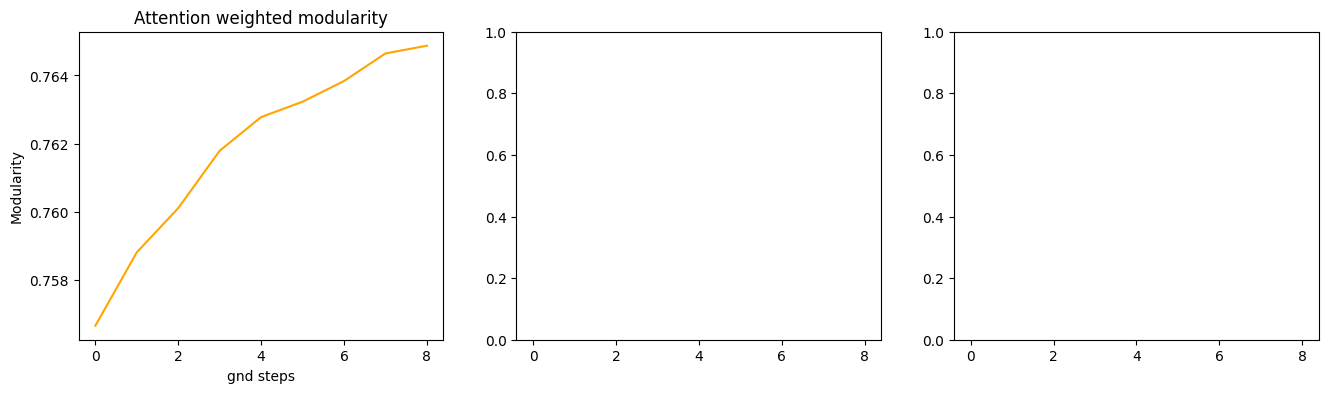

In [29]:
view_modularity(gnd_modularity, save_fig=None)